This notebook is guided by the Book Recommender System article by Susan Li (2017) in [Toward Data Science](https://towardsdatascience.com/how-did-we-build-book-recommender-systems-in-an-hour-part-2-k-nearest-neighbors-and-matrix-c04b3c2ef55c). I've provided additional explantory notes and resources for my own understanding; and modified the code from the original project to provide additonal functionality and analysis. Other modification have been made to account for incomplete code and depreciated methods/techniques used in the initial article.

### Collaborative Filtering
- Purpose
- Similarity : Cosine Similarity

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import sklearn
from sklearn.decomposition import TruncatedSVD

### Data Summary and Import
The Book-Crossing Dataset was sourced from the Institut Fur Informatik Freiburg website. Full citation can be found in the Resouces section of this notebook. 

The Book-Crossing dataset comprises 3 tables.

+ BX-Users
> Contains the users. Note that user IDs (`User-ID`) have been anonymized and map to integers. Demographic data is provided (`Location`, `Age`) if available. Otherwise, these fields contain NULL-values.

+ BX-Books
> Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (`Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavours (`Image-URL-S`, `Image-URL-M`, `Image-URL-L`), i.e., small, medium, large. These URLs point to the Amazon web site.

+ BX-Book-Ratings
> Contains the book rating information. Ratings (`Book-Rating`) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

In [5]:
book = pd.read_csv('data/BX-Books.csv', sep=';', on_bad_lines= 'skip', encoding = "latin-1")
book.columns = ['ISBN','bookTitle', 'bookAuthor','yearOfPublication','publisher','imageUrlS','imageUrlM','imageUrlL']
user = pd.read_csv('data/BX-Users.csv', sep=';', on_bad_lines= 'skip', encoding = "latin-1")
user.columns= ['userID','Location','Age']
rating = pd.read_csv('data/BX-Book-Ratings.csv', sep=';', on_bad_lines= 'skip', encoding = "latin-1")
rating.columns = ['userID','ISBN','bookRating']

# DTypeWarning on BX-Books.csv import



/tmp/ipykernel_87/1814702560.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  book = pd.read_csv('data/BX-Books.csv', sep=';', on_bad_lines= 'skip', encoding = "latin-1")


#####  Book Dataframe Info

In [6]:
book.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [17]:
b_records, b_attributes = book.shape
print(f'book dataframe has {b_records} records and {b_attributes} features')

book dataframe has 271360 records and 8 features


#####  User Dataframe Info


In [9]:
user.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [18]:
u_records, u_attributes = user.shape
print(f'user data frame has {u_records} records and {u_attributes} features')

user data frame has 278858 records and 3 features


#####  Rating Dataframe Info

In [8]:
rating.head()

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [19]:
r_records, r_attributes = rating.shape
print(f'rating data frame has {r_records} records and {r_attributes} features')

rating data frame has 1149780 records and 3 features


### Data Wrangling

In this section we will combine the `book` and `rating` dataframes to find the most popular books and calculate a new field `totalRatingCount`, then review the statistics of the field. The `totalRatingcount` will allow us to query our new dataframe for books that meet a specified ratings count threshold. In this case we will use data from books that have received atleast 50 ratings to create our recommender system. 

In [27]:
#merge books and rating based on ISBN (unique identifier)
book_rating = pd.merge(rating,book,on='ISBN') 


#columns to be removed 
columns = ['yearOfPublication','publisher','bookAuthor','imageUrlS','imageUrlM','imageUrlL'] 
book_rating = book_rating.drop(columns,axis=1) 

book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,276725,034545104X,0,Flesh Tones: A Novel
1,2313,034545104X,5,Flesh Tones: A Novel
2,6543,034545104X,0,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel


In [29]:
#drop index with missing booktitle
book_rating = book_rating.dropna(axis=0,subset=['bookTitle'])

In [30]:
#create new dataframe with totalratingcount
book_ratingCount = (book_rating.
                    groupby(by = ['bookTitle'])['bookRating'].
                    count().
                    reset_index().
                    rename(columns= {'bookRating':'totalRatingCount'})[['bookTitle','totalRatingCount']]
                   )
book_ratingCount.head()

,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


In [31]:
rating_with_totalRatingCount = book_rating.merge(book_ratingCount, left_on='bookTitle', right_on = 'bookTitle', how='right')
rating_with_totalRatingCount.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,18995,0590567330,0,A Light in the Storm: The Civil War Diary of ...,4
1,35859,0590567330,0,A Light in the Storm: The Civil War Diary of ...,4
2,55927,0590567330,0,A Light in the Storm: The Civil War Diary of ...,4
3,96448,0590567330,9,A Light in the Storm: The Civil War Diary of ...,4
4,172742,0964147726,0,Always Have Popsicles,1


##### Statistics Summary of totalRatingCount

In [33]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['totalRatingCount'].describe())

count   241071.000
mean         4.277
std         16.739
min          1.000
25%          1.000
50%          1.000
75%          3.000
max       2502.000
Name: totalRatingCount, dtype: float64


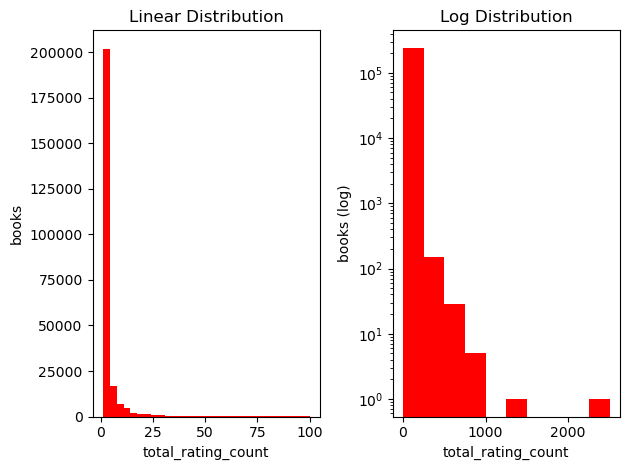

In [81]:
plt.subplot(1, 2, 1)
plt.hist(book_ratingCount['totalRatingCount'], range=[1,100], bins =30, color = 'red')
plt.title('Linear Distribution')
plt.xlabel('total_rating_count')
plt.ylabel('books')

plt.subplot(1, 2, 2)
plt.hist(book_ratingCount['totalRatingCount'],  color = 'red', log=True)
plt.title('Log Distribution')
plt.xlabel('total_rating_count')
plt.ylabel('books (log)')

plt.tight_layout()
plt.show()

We observe a right skew of the `totalRatingCount` data both in the statistics summary in comparing the mean vs the median, and visually in both the linear and log histogram distributions. The majority of the books in our data have received one rating. We set the rating threshold to at least 50 ratings to utilize the most popular books in our recommender system; this represents ~1% of our books.

In [80]:
print(book_ratingCount['totalRatingCount'].quantile(np.arange(.9,1,.01)))

0.900    7.000
0.910    8.000
0.920    9.000
0.930   10.000
0.940   11.000
0.950   13.000
0.960   16.000
0.970   20.000
0.980   29.000
0.990   50.000
Name: totalRatingCount, dtype: float64


In [84]:
 # %whos


In [83]:
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_book.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
561,27740,0399143025,0,10 Lb. Penalty,61
562,55548,0399143025,0,10 Lb. Penalty,61
563,94923,0399143025,0,10 Lb. Penalty,61
564,108700,0399143025,0,10 Lb. Penalty,61
565,111747,0399143025,8,10 Lb. Penalty,61


In [89]:
#merge user dataframe with rating_popular_book dataframe
combined = rating_popular_book.merge(user,left_on = 'userID', right_on = 'userID', how='left')

#filter by country: US or Canada
us_ca_user_rating = combined[combined['Location'].str.contains("usa|canada")]
us_ca_user_rating = us_ca_user_rating.drop('Age',axis=1)
us_ca_user_rating.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location
0,27740,0399143025,0,10 Lb. Penalty,61,"san diego, , usa"
1,55548,0399143025,0,10 Lb. Penalty,61,"chamblee, georgia, usa"
2,94923,0399143025,0,10 Lb. Penalty,61,"brick, new jersey, usa"
3,108700,0399143025,0,10 Lb. Penalty,61,"orlando, florida, usa"
4,111747,0399143025,8,10 Lb. Penalty,61,"plantation, florida, usa"


### Recommender System Implementation

#### Resources: 
Collaborative Filtering
+ Data Science Concepts: https://www.youtube.com/watch?v=Fmtorg_dmM0